In [3]:
import pandas as pd 
import fastai

df = pd.read_csv("downloads/40k_balanced_pm_acl.csv").sample(frac=1)
df = df.dropna(subset=["labels"])
df["text_nomask"] = df["text"] #backup
print(len(df))
df_test = df[:300]
df = df[300:]
fastai.__version__, len(df)

42140


('2.5.2', 41840)

In [20]:
df = df[df["text_length"] > 7]
len(df)

40474

In [ ]:
from octoflow.core import replace_outof_vocab_words, vocab30k

df["text"] = df["text"].map(lambda t: replace_outof_vocab_words(t, vocab30k))
df_test["text"] = df_test["text"].map(lambda t: replace_outof_vocab_words(t,vocab30k))

In [ ]:
df["text"] = df["text"].astype(str)
df["labels"] = df["labels"].astype(int)

In [ ]:
df = df[(df["labels"] == 1) | (df["labels"] == 0)]
df["lab"] = df["labels"] #worst fastai bug in history

In [ ]:
from fastai.text.all import *
dls = TextDataLoaders.from_df(df, text_col='text', label_col='lab')

/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos iicd , if all of the a ; , are in a then so is at least one of the iinnp ; , ii . xxmaj in fact , the other two conditions are just special cases of this condition . iinnp the assertion component of the latter is essentially limited to atomic iinns and their iinns , so that ordinary statements such as xxmaj most students who passed the xxup ai exam also passed the theory exam , or xxmaj if xxmaj kim and xxmaj sandy get divorced , then xxmaj kim will probably get custody of their children , can not be represented , let alone reasoned with",0
1,"xxbos xxmaj in this iijj study , patients with personality disorders -lrb- n ii_sp iisym ii_sp iicd -rrb- treated at iinnp xxmaj psychotherapy xxmaj xxunk , xxmaj mental xxmaj health xxmaj services , xxmaj xxunk xxmaj xxunk of xxmaj xxunk were xxunk to two different kinds of treatment ii : a standardized treatment package with a xxunk number of treatment hours -lrb- basic hospital service -rrb- and iils ii : a specialized treatment program for the most severely affected patients without a iivbn restricted number of treatment hours and significantly more individual psychotherapy -lrb- xxunk...",0
2,"xxbos xxmaj examples are iijj clauses ii , these are an old xxmaj indo iihyph xxmaj european feature which most modern xxmaj european languages have lost ii : , extensive use of complex iinn , and rampant pro iijj drop . using only those iinnps that exactly match clean lists leaves out some good data -lrb- iirb , a tuple with an iinn of ii ` ` xxmaj univ of xxmaj wash ii '' will not match against a list of universities that spells it as ii ` ` xxmaj university of xxmaj washington ii '' -rrb-",0
3,"xxbos xxmaj examples are iijj clauses ii , these are an old xxmaj indo iihyph xxmaj european feature which most modern xxmaj european languages have lost ii : , extensive use of complex iinn , and rampant pro iijj drop . using only those iinnps that exactly match clean lists leaves out some good data -lrb- iirb , a tuple with an iinn of ii ` ` xxmaj univ of xxmaj wash ii '' will not match against a list of universities that spells it as ii ` ` xxmaj university of xxmaj washington ii '' -rrb-",0
4,"xxbos xxmaj for suffix separation , we identify a number of linguistic rules for both xxmaj tamil and xxmaj english . in assigning an induced word cluster to a known target category , such as noun , and evaluating the goodness of the cluster according to how well it represents the class noun , the assumption is made that it is fine for a target class to be represented by multiple induced clusters , but it is unacceptable for a single induced category to represent a combination of multiple target categories",0
5,"xxbos xxmaj for suffix separation , we identify a number of linguistic rules for both xxmaj tamil and xxmaj english . in assigning an induced word cluster to a known target category , such as noun , and evaluating the goodness of the cluster according to how well it represents the class noun , the assumption is made that it is fine for a target class to be represented by multiple induced clusters , but it is unacceptable for a single induced category to represent a combination of multiple target categories",0
6,"xxbos xxmaj for suffix separation , we identify a number of linguistic rules for both xxmaj tamil and xxmaj english . in assigning an induced word cluster to a known target category , such as noun , and evaluating the goodness of the cluster according to how well it represents the class noun , the assumption is made that it is fine for a target class to be represented by multiple induced clusters , but it is unacceptable for a single induced category to represent a combination of multiple target categories",0
7,"xxbos a major limitation of xxunk natural language to xxup xxunk iihyph xxup xxunk is that the assertion component of the latter is essentially limited to atomic iinns and their iinns , so that ordinary statements such as xxmaj most students who passed the xxu

epoch     train_loss  valid_loss  accuracy  fbeta_score  time    
0         0.622685    0.469395    0.786260  0.611111     00:02     
epoch     train_loss  valid_loss  accuracy  fbeta_score  time    
0         0.478588    0.542257    0.741985  0.606061     00:03     
1         0.422714    0.288439    0.879389  0.752351     00:03     
2         0.346093    0.277274    0.882443  0.744186     00:03     
3         0.290636    0.261418    0.890076  0.755102     00:03     


,text,category,category_
0,"xxbos iicd , if all of the a ; , are in a then so is at least one of the iinnp ; , ii . xxmaj in fact , the other two conditions are just special cases of this condition . iinnp the assertion component of the latter is essentially limited to atomic iinns and their iinns , so that ordinary statements such as xxmaj most students who passed the xxup ai exam also passed the theory exam , or xxmaj if xxmaj kim and xxmaj sandy get divorced , then xxmaj kim will probably get custody of their children , can not be represented , let alone reasoned with",0,0
1,"xxbos iicd , if all of the a ; , are in a then so is at least one of the iinnp ; , ii . xxmaj in fact , the other two conditions are just special cases of this condition . iinnp the assertion component of the latter is essentially limited to atomic iinns and their iinns , so that ordinary statements such as xxmaj most students who passed the xxup ai exam also passed the theory exam , or xxmaj if xxmaj kim and xxmaj sandy get divorced , then xxmaj kim will probably get custody of their children , can not be represented , let alone reasoned with",0,0
2,"xxbos a iinn which is common to all of these approaches using a ii ` ` xxunk correct ii '' measurement to evaluate models of part iihyph of iihyph speech xxunk is that in assigning an induced word cluster to a known target category , such as noun , and evaluating the goodness of the cluster according to how well it represents the class noun , the assumption is made that it is fine for a target class to be represented by multiple induced clusters , but it is unacceptable for a single induced category to represent a combination of multiple target categories",1,0
3,"xxbos xxmaj although patients receiving iinn -lrb- iinnp -rrb- have significantly different backgrounds , including a history of progressive iijj disease , compared with those not receiving iinn -lrb- iinns -rrb- , there are no studies evaluating the risks for loss of primary iinn -lrb- xxup xxunk -rrb- and need for target lesion iinn -lrb- iinnp -rrb- in iijj patients following xxunk self iihyph xxunk iinn iinn -lrb- iinnp -rrb- implantation to iivb -lrb- xxup xxunk -rrb- artery iijj lesions , after adjusting for differences using iinn score -lrb- xxup ps -rrb- analysis in observed charac...",0,0
4,"xxbos xxmaj examples are iijj clauses ii , these are an old xxmaj indo iihyph xxmaj european feature which most modern xxmaj european languages have lost ii : , extensive use of complex iinn , and rampant pro iijj drop . using only those iinnps that exactly match clean lists leaves out some good data -lrb- iirb , a tuple with an iinn of ii ` ` xxmaj univ of xxmaj wash ii '' will not match against a list of universities that spells it as ii ` ` xxmaj university of xxmaj washington ii '' -rrb-",0,0
5,"xxbos xxmaj the iijj structure of ii ` ` ii ` ` switching ii '' is ii : ii ` ` ii ` ` schools ii '' ii : agent ii : ; ii ` ` ii ` ` constantly ii '' ii : time iisym frequency ii , ; ii ` ` ii ` ` uniforms ii '' ii : theme iiuh . the resulting reliance on manually annotated examples , which are expensive and time iihyph consuming to create",0,0
6,"xxbos xxmaj bridging the two are genres such as discussion boards , web iinnp , and mailing lists . they strongly depend on the arbitrarily defined window size parameter and do not iivb all error types equally , iirb , pk iivbz false negatives more than false positives and wd iivbz false positive and negative boundaries more at the beginning and end of the text -lrb- iinnp , et al . , iicd -rrb-",0,0
7,"xxbos xxmaj xxunk the answer of a yes iisym no query is simply a matter of parsing a query , adding its semantic parse to the xxup kb , and iivbg the xxunk function ii : which is iijj in iinnp iiuh . the fact that the iinn of iinn at the micro iijj planning level is restricted to the iinn and the linguistic realization of rhetorical relations",0,0
8,"xxbos xxmaj an equivalent notation , using the xxmaj xerox ii ` 

,input,target,predicted,probability,loss
0,xxbos xxmaj evidence for treating iijj iinn with acupuncture is xxunk .,1,0,0.9905828237533569,4.66521692276001
1,xxbos xxmaj xxunk skin biopsies are essential procedures xxunk physicians diagnose iijj lesions .,1,0,0.9815025925636292,3.9901232719421387
2,xxbos xxmaj addressing xxunk dependence is key to effective xxunk xxunk,1,0,0.9788379669189453,3.855548620223999


('0', tensor(0), tensor([0.9287, 0.0713]))

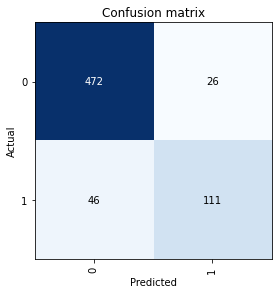

In [ ]:
dls.show_batch()

learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(beta=1)])
learn.fine_tune(4, 1e-2)
learn.show_results()
learn.save("model_3")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(3)  
interp.plot_confusion_matrix()

learn.predict("We discuss the implications of a more 'civic-minded journalism.")

In [ ]:
predicts = df_test["text"].map(learn.predict)

In [ ]:
df_test["predicted"] = [int(p[0]) for p in predicts]
df_test["confidence_0"] =  [round(p[2][0].item(),2) for p in predicts]
df_test["confidence_1"] =  [round(p[2][1].item(),2) for p in predicts]

In [ ]:
mkdir downloads

In [ ]:
df_test.to_csv("downloads/oct7_test300.csv")

In [ ]:
print("accuracy in test set:", len(df_test[df_test["predicted"] == df_test["labels"]])/len(df_test))

accuracy in test set: 0.8966666666666666


In [ ]:
predicts2 = df_test["text_nomask"].map(learn.predict)

In [ ]:
df_test["predicted2"] = [int(p[0]) for p in predicts2]
print("accuracy in test set with no masking:", len(df_test[df_test["predicted2"] == df_test["labels"]])/len(df_test))

accuracy in test set with no masking: 0.8966666666666666


That's very weird ... masking doesn't effect predictions